# Week 6: Generative adversarial network (GAN) 

written by Jihoon-Tack (jihoontack@kaist.ac.kr) 

- We will cover basic concepts of GAN & implement vanilla GAN \[[Goodfellow et al., NIPS 2014](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)\]
- We will give basic skeletone code which include (1) training structure (2) sample visualization (3) FID evaluation
- You should implement (1) ***generator & discriminator architecture*** (2) ***noise sampling***  (3) ***GAN loss*** 
- Additionally, will give you [DCGAN](https://arxiv.org/abs/1511.06434) (basic GAN architecture) code that you can enjoy by your-self 

If you have any questions, feel free to ask
- For additional questions, send emails to mjbooo@kaist.ac.kr

## 0. Preliminary

### 0.1. Prelim step 1: Load packages & GPU setup

In [1]:
# visualize current GPU usages in your server
!nvidia-smi 

Wed Oct  6 12:48:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# set gpu by number 
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

In [3]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [4]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
    
if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
    
if not os.path.exists('./img'):
    os.mkdir('./img')
    
if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

### 0.2. Prelim step 2: Define visualization & image saving code

In [5]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [6]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./img/training_progress.gif', training_progress_images)
    return training_progress_images

In [7]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [8]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [9]:
def save_image_list(dataset, real):
    if real:
        base_path = './img/real'
    else:
        base_path = './img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

### 0.3. Prelim step 3: Load dataset, define dataloader

![picture](https://drive.google.com/uc?id=1kdig6RLSCvYJNqarbb8gviYsnxZfSkYQ)


In this class we will use **MNIST** (or you can use **Fashion-MNIST**) due to the time constraint :( \
You can practice with CIFAR-10 by your-self since dataset is already implemented inside PyTorch!
- Simply use `dataset=dset.CIFAR10(.)` function in PyTorch.
- If you are using CIFAR dataset, please note that the resolution is different to MNIST and should change model input dimension.

In [10]:
dataset = dset.MNIST(root="./dataset", download=True,
                                   transform=transforms.Compose([
                                   transforms.ToTensor(),
                ]))
# If you want to download FMNIST use dset.FashionMNIST
# dataset = dset.FashionMNIST(.)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 1. Define your generator & discriminator

### 1.1. Define generator module

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #########################
            # Define your own generator #
            #########################
            
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(), # 0 - 1
            
            #########################
        )

    def forward(self, input):
        #####################################
        # Change the shape of output if necessary #
        
        # input shape = batch_size, 100
        #####################################
        
        output = self.main(input)
        
        #####################################
        # Change the shape of output if necessary #
        
        # output shape = batch_size, 1, 28, 28
        output = output.view(-1, 1, 28, 28)
        
        #####################################
        return output

### 1.2. Define discriminator module

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            ############################
            # Define your own discriminator #
            ############################
            
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            
            ############################
        )

    def forward(self, input):
        #####################################
        # Change the shape of output if necessary #
        input = input.view(-1, 28*28)
        #####################################
        
        output = self.main(input)
        
        #####################################
        # Change the shape of output if necessary # (batch_size, 1) -> (batch_size, )
        output = output.squeeze(dim=1)
        #####################################
        
        return output

In [13]:
dataset.data.shape  # B, W, H

torch.Size([60000, 28, 28])

### 1.3. Upload on GPU, define optimizer

In [14]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

## 2. Noise sampling

In [15]:
#### Implement here ####
noise = torch.randn(128, 100).cuda()

## 3. Train GAN

Implement GAN by filling out the following blankes!

In [26]:
fixed_noise = torch.randn(128, 100).cuda()

criterion = nn.BCELoss()

n_epoch = 200
training_progress_images_list = []
for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        ####################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###################################################
        # train with real
        netD.zero_grad()
        data = data.cuda()
        batch_size = data.size(0)
        label = torch.ones((batch_size,)).cuda() # real label = 1
        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, 100).cuda()
        fake = netG(noise)
        label = torch.zeros((batch_size,)).cuda() # fake label = 1
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        
        # Loss backward
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ########################################
        # (2) Update G network: maximize log(D(G(z))) #
        ########################################
        netG.zero_grad()
        label = torch.ones((batch_size,)).cuda()  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()
        
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    #save the output
    fake = netG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

[0/200] Loss_D: 0.0140 Loss_G: 6.1194 D(x): 0.9911 D(G(z)): 0.0043 / 0.0022
[1/200] Loss_D: 0.0031 Loss_G: 6.9082 D(x): 0.9987 D(G(z)): 0.0018 / 0.0010
[2/200] Loss_D: 0.0016 Loss_G: 7.5178 D(x): 0.9993 D(G(z)): 0.0009 / 0.0006
[3/200] Loss_D: 0.0383 Loss_G: 6.4528 D(x): 0.9725 D(G(z)): 0.0040 / 0.0016
[4/200] Loss_D: 0.0015 Loss_G: 7.8294 D(x): 0.9996 D(G(z)): 0.0011 / 0.0004
[5/200] Loss_D: 0.0169 Loss_G: 6.1179 D(x): 0.9902 D(G(z)): 0.0037 / 0.0023
[6/200] Loss_D: 0.0093 Loss_G: 5.6189 D(x): 0.9988 D(G(z)): 0.0081 / 0.0040
[7/200] Loss_D: 0.0282 Loss_G: 5.7676 D(x): 0.9892 D(G(z)): 0.0157 / 0.0035
[8/200] Loss_D: 0.0211 Loss_G: 7.7606 D(x): 0.9870 D(G(z)): 0.0004 / 0.0005
[9/200] Loss_D: 0.0320 Loss_G: 6.3573 D(x): 0.9776 D(G(z)): 0.0048 / 0.0028
[10/200] Loss_D: 0.0028 Loss_G: 7.8436 D(x): 0.9997 D(G(z)): 0.0024 / 0.0008
[11/200] Loss_D: 0.0017 Loss_G: 7.7754 D(x): 0.9999 D(G(z)): 0.0016 / 0.0006
[12/200] Loss_D: 0.0079 Loss_G: 5.8355 D(x): 0.9986 D(G(z)): 0.0064 / 0.0041
[13/200] 

## 4. Visualize/Plot your generated samples

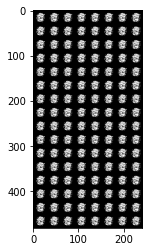

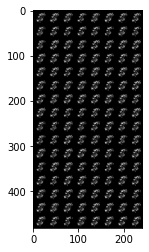

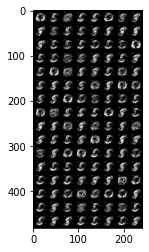

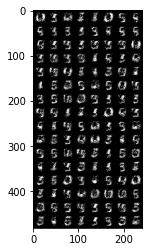

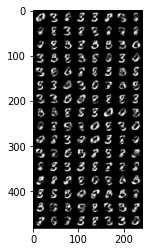

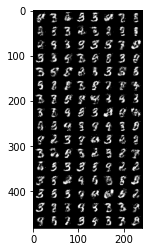

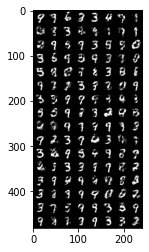

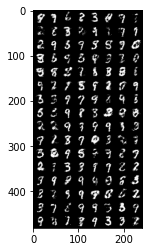

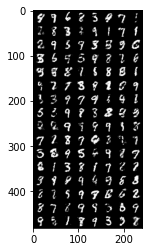

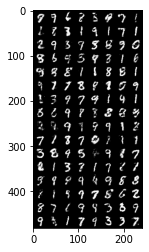

In [27]:
# vis_gif(training_progress_images_list)
plot_gif(training_progress_images_list)

## 5. Evaluate your model: Fréchet Inception Distance (FID) score

How to evaluate the equality of your generated sample?\
Maybe **training loss...? No!**
Papers have shown that training loss might not be the best metric!

There are many evaluation metric that has been proposed and most famous metric is as follows: [**Inception score**](https://arxiv.org/abs/1606.03498), [**Fréchet Inception Distance**](https://arxiv.org/abs/1706.08500)

In this course, we will handle **Fréchet Inception Distance (FID) score.**

### 5.1. What is FID score?

FID measures the distance between **real dataset** & **fake dataset** in **feature space of Inception** pretrained network.\
From the extracted features of real & fake dataset, we can compute mean & covariance of each features to calculate the **distance between distributions**.
- For more explanation see this [article](https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732) or [paper](https://arxiv.org/abs/1706.08500)

For the implementation, we simply use the source code from github: https://github.com/mseitzer/pytorch-fid

Please note that Inception network is **pretrained on ImageNet**, therefore the MNIST FID score might be unrealiable.\

### 5.2. Load FID score function: code is from the github

In [28]:
import inception
import fid_score
from fid_score import calculate_fid_given_paths

### 5.3. Evaluate your model (save samples!!)

The Inception network's input resolution is 224 by 224, we upscale small resolution datasets (e.g., MNSIT, CIFAR) into same resolution.

Please note that, we only save *50 samples in this lecture*, however in practice we use **full test dataset**: [reference](https://arxiv.org/abs/1807.04720)

In [29]:
test_dataset = dset.MNIST(root="./dataset", download=True, train=False,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                        ]))

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=2)

for i, (data, _) in enumerate(dataloader):
    real_dataset = data
    break
    
noise = torch.randn(50, 100).cuda()
fake_dataset = netG(noise)

In [30]:
real_image_path_list = save_image_list(real_dataset, True)
fake_image_path_list = save_image_list(fake_dataset, False)

### 5.4 Evaluate FID score

In [31]:
# calculate_fid_given_paths(paths, batch_size, cuda, dims)
fid_value = calculate_fid_given_paths([real_image_path_list, fake_image_path_list],
                                                          50, 
                                                          True,
                                                          2048)

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


In [32]:
print (f'FID score: {fid_value}')

FID score: 123.28376531237436


## Additional: DCGAN (try it by your-self)

There are various modern architectures of GAN e.g., DCGAN, SNGAN, and also training methods e.g., WGAN, gradient penulty

You can try the following architecture to improve the quality of generation!
- **Note that this version is for 64 by 64 resolution**

In [24]:
nc = 3 # number of channels, RGB
nz = 100 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 #number of discriminator filters

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

## Reference

PyTorch official DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html \
github 1: https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py \
github 2: https://github.com/mseitzer/pytorch-fid \
FID score: https://github.com/mseitzer/pytorch-fid \
Inception score: https://github.com/sbarratt/inception-score-pytorch